In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
#  import Utils
from utils.constants import SAMPLE_RATE, BANDS
from utils.import_data import import_all_data
from featextr.feature_extraction import exctract_features_from_signals, node_strengths_features, extract_psd_features
from filter.filter import bandpass
from utils.plot_fig import (
    plot_avg_roc_curve,
    plot_accuracies,
    plot_losses
)

In [3]:
from classification.gcn import GCNClassifier, GraphDataset, DataLoader

%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="whitegrid")

In [5]:
signals, labels = import_all_data("../data")

Data loaded successfully!ults32.csv...


Filter signals and keep the frequency bands

In [ ]:
filtered_signals = [[bandpass(signal.to_numpy(), SAMPLE_RATE, (band[0], band[1]), band[2]) for band in BANDS] for signal in signals]
aggragated_signals = [np.mean(filtered_signal, axis=0) for filtered_signal in filtered_signals]
agg_features = [exctract_features_from_signals(aggrated) for aggrated in aggragated_signals]

<h1>Feature Extraction</h1>

In [6]:
features_sig = [exctract_features_from_signals(signal) for signal in signals]

In [ ]:
psd_features = [extract_psd_features(aggregated, SAMPLE_RATE) for aggregated in aggragated_signals]

<h1>Load Graphs</h1>

In [8]:
graphs_iplv, _ = import_all_data("../graphs/aggregated/IPLV")
graphs_iplv = [graph.to_numpy() for graph in graphs_iplv]

for g in graphs_iplv:
    norm = np.linalg.norm(g)
    g = g/norm

graphs_mi, _ = import_all_data("../graphs/aggregated/MI")
graphs_mi = [graph.to_numpy() for graph in graphs_mi]

for g in graphs_mi:
    norm = np.linalg.norm(g)
    g = g/norm
    
graphs_aec, _ = import_all_data("../graphs/aggregated/AEC")
graphs_aec = [graph.to_numpy() for graph in graphs_aec]

for g in graphs_aec:
    norm = np.linalg.norm(g)
    g = g/norm

Data loaded successfully!
Data loaded successfully!
Data loaded successfully!


Add Node Strength Feature

In [11]:
features_iplv = []
for i, graph in enumerate(graphs_iplv):
    strength_feature = node_strengths_features(graphs_iplv[i]).reshape(1, -1)  # Reshape to (1, 90)
    features_iplv.append(np.vstack([features_sig[i], strength_feature]))

features_mi = []
for i, graph in enumerate(graphs_mi):
    strength_feature = node_strengths_features(graphs_mi[i]).reshape(1, -1)  # Reshape to (1, 90)
    features_mi.append(np.vstack([features_sig[i], strength_feature]))

features_aec = []
for i, graph in enumerate(graphs_aec):
    strength_feature = node_strengths_features(graphs_aec[i]).reshape(1, -1)  # Reshape to (1, 90)
    features_aec.append(np.vstack([features_sig[i], strength_feature]))

<h1>GCN</h1>

In [12]:
gcn_iplv = GCNClassifier()
gcn_mi = GCNClassifier()
gcn_aec = GCNClassifier()

In [ ]:
gcn.classify(feature_data=features_sig, adj_matrices=graphs, labels=labels)

In [14]:
gcn_iplv.hyperparameter_tuning(feature_data=features_iplv, adj_matrices=graphs_iplv, labels=labels)

100%|██████████| 25/25 [6:43:24<00:00, 968.16s/trial, best loss: -0.9833333333333332]   
╒═════════════════╤════════════════╤══════════╕
│   Learning Rate │   Weight Decay │    Gamma │
╞═════════════════╪════════════════╪══════════╡
│     0.000264233 │      0.0021641 │ 0.803186 │
╘═════════════════╧════════════════╧══════════╛


In [15]:
gcn_mi.hyperparameter_tuning(feature_data=features_mi, adj_matrices=graphs_mi, labels=labels)

100%|██████████| 25/25 [1:32:09<00:00, 221.19s/trial, best loss: -0.9833333333333332]
╒═════════════════╤════════════════╤══════════╕
│   Learning Rate │   Weight Decay │    Gamma │
╞═════════════════╪════════════════╪══════════╡
│      0.00020946 │    0.000183456 │ 0.872196 │
╘═════════════════╧════════════════╧══════════╛


In [16]:
gcn_aec.hyperparameter_tuning(feature_data=features_aec, adj_matrices=graphs_aec, labels=labels)

100%|██████████| 25/25 [1:36:01<00:00, 230.48s/trial, best loss: -1.0]               
╒═════════════════╤════════════════╤══════════╕
│   Learning Rate │   Weight Decay │    Gamma │
╞═════════════════╪════════════════╪══════════╡
│      0.00164733 │    0.000530466 │ 0.898743 │
╘═════════════════╧════════════════╧══════════╛


In [ ]:
dataset = GraphDataset(features_sig, graphs, labels)
dataset_loader = DataLoader(dataset, batch_size=1, shuffle=False)
y, preds = gcn.predict(dataset_loader)
print(y)
print(preds)

ets: [1 1 1 1 1 1 0 0 0 0 0 0]	predicted: [1 1 1 1 1 0 0 0 0 0 0 0]              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       0.97      0.97      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

              precision    recall  f1-score   support1 0 0 0 0 0 0]

           0       0.97      1.00      0.98        30
           1       1.00      0.97      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60

              precision    recall  f1-score   support1 0 0 0 0 0 0]

           0       0.97      0.97      0.97        30
           1       0.97      0.97      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97

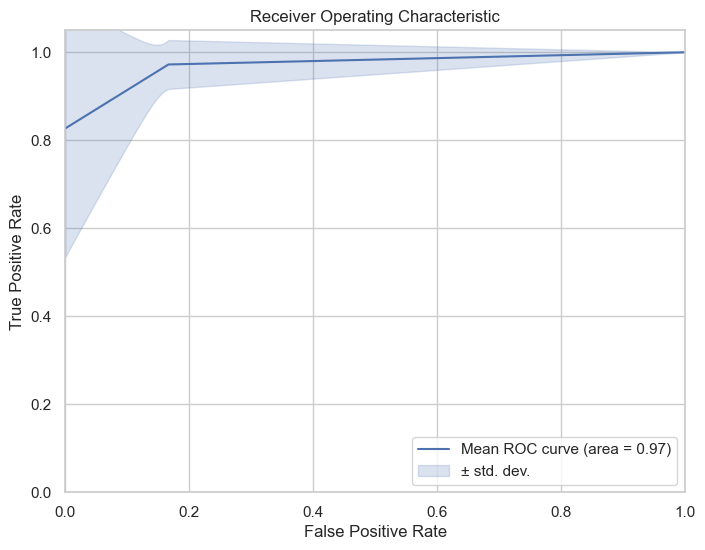

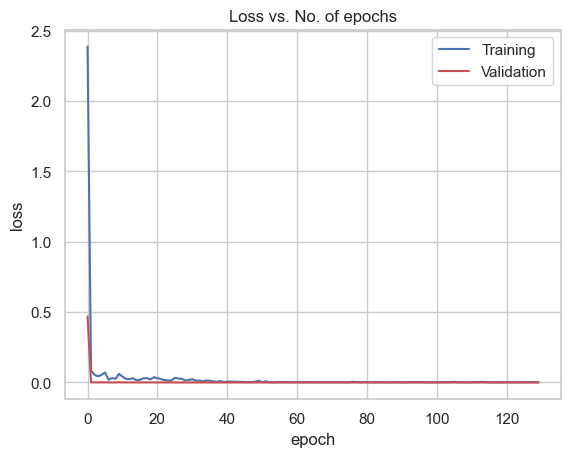

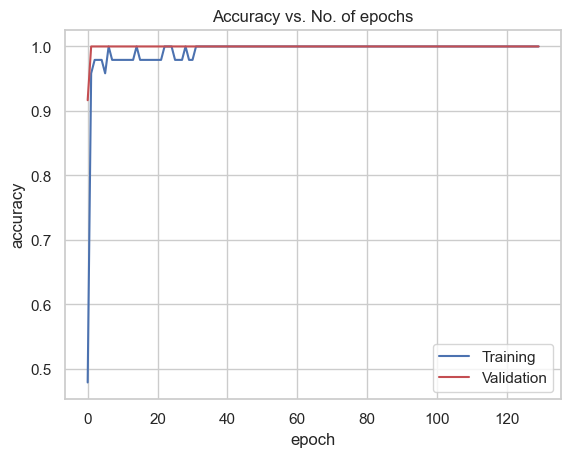

In [17]:
#   Accuracies
accs = []
stds = []

#   ROC AUCs
all_mean_fprs = []
all_mean_tprs = []
all_std_tprs = []
all_aucs = []

hist = None
best_acc = 0.0

#   cross_validate
for _ in range(20):
    acc_params, roc_params, history = gcn_iplv.cross_validate(features_iplv, graphs_iplv, labels, 5, verbose=False)
    accs.append(acc_params[0])
    stds.append(acc_params[1])
    
    all_mean_fprs.append(roc_params[0])
    all_mean_tprs.append(roc_params[1])
    all_std_tprs.append(roc_params[2])
    all_aucs.append(roc_params[3])
    
    if (acc_params[0] > best_acc):
        hist = history
        best_acc = acc_params[0]

#   Print results
print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accs), np.mean(stds)))

mean_mean_fpr = np.mean(all_mean_fprs, axis=0)
mean_mean_tpr = np.mean(all_mean_tprs, axis=0)
mean_std_tpr = np.mean(all_std_tprs, axis=0)
mean_auc = np.mean(all_aucs)

#   Plot
plot_avg_roc_curve(mean_mean_fpr, mean_mean_tpr, mean_std_tpr, mean_auc)
plot_losses(hist)
plot_accuracies(hist)

              precision    recall  f1-score   support1 0 0 0 0 0 0]

           0       0.97      0.97      0.97        30
           1       0.97      0.97      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

              precision    recall  f1-score   support1 0 0 1 0 0 0]

           0       0.97      0.97      0.97        30
           1       0.97      0.97      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

              precision    recall  f1-score   support1 0 0 0 0 0 0]

           0       0.97      0.97      0.97        30
           1       0.97      0.97      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.9

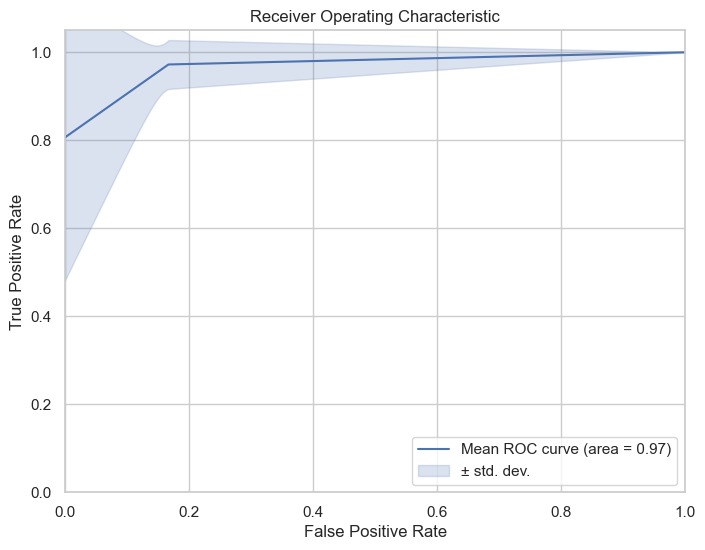

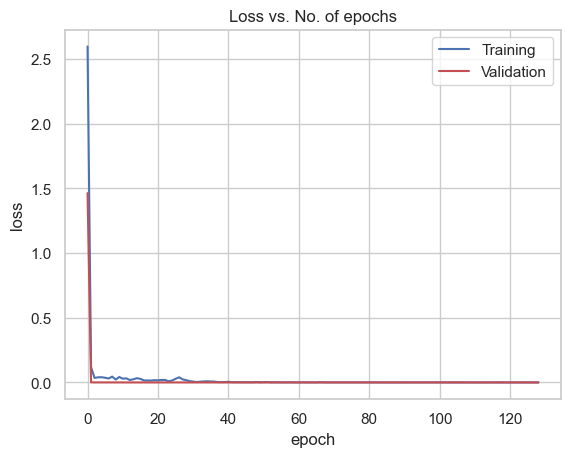

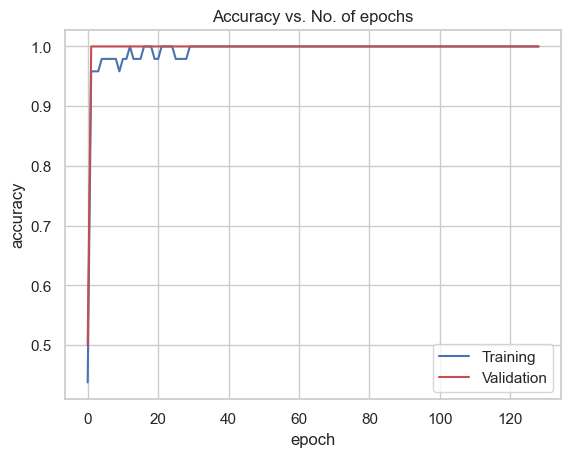

In [18]:
#   Accuracies
accs = []
stds = []

#   ROC AUCs
all_mean_fprs = []
all_mean_tprs = []
all_std_tprs = []
all_aucs = []

hist = None
best_acc = 0.0

#   cross_validate
for _ in range(20):
    acc_params, roc_params, history = gcn_mi.cross_validate(features_mi, graphs_mi, labels, 5, verbose=False)
    accs.append(acc_params[0])
    stds.append(acc_params[1])
    
    all_mean_fprs.append(roc_params[0])
    all_mean_tprs.append(roc_params[1])
    all_std_tprs.append(roc_params[2])
    all_aucs.append(roc_params[3])
    
    if (acc_params[0] > best_acc):
        hist = history
        best_acc = acc_params[0]

#   Print results
print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accs), np.mean(stds)))

mean_mean_fpr = np.mean(all_mean_fprs, axis=0)
mean_mean_tpr = np.mean(all_mean_tprs, axis=0)
mean_std_tpr = np.mean(all_std_tprs, axis=0)
mean_auc = np.mean(all_aucs)

#   Plot
plot_avg_roc_curve(mean_mean_fpr, mean_mean_tpr, mean_std_tpr, mean_auc)
plot_losses(hist)
plot_accuracies(hist)

              precision    recall  f1-score   support1 0 0 0 0 0 0]

           0       0.97      0.97      0.97        30
           1       0.97      0.97      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

              precision    recall  f1-score   support1 0 0 0 0 0 0]

           0       0.97      1.00      0.98        30
           1       1.00      0.97      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60

              precision    recall  f1-score   support1 0 0 0 0 0 0]

           0       0.97      1.00      0.98        30
           1       1.00      0.97      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.9

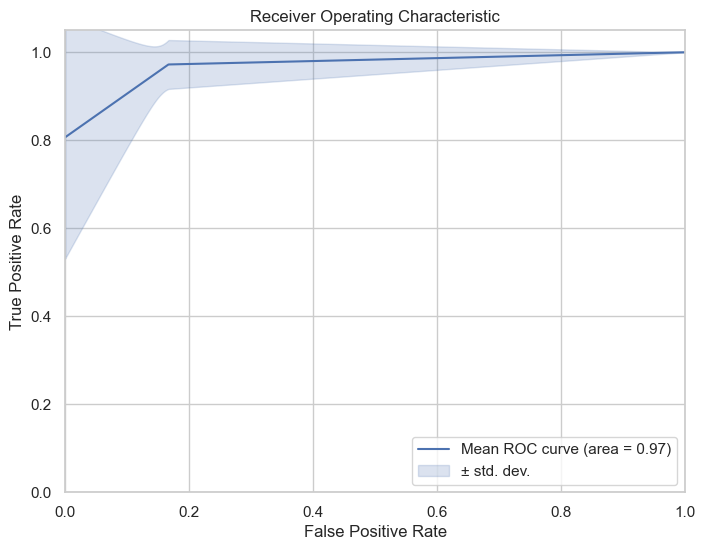

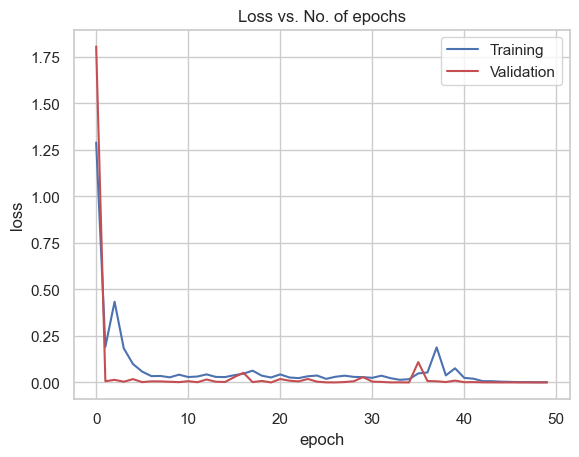

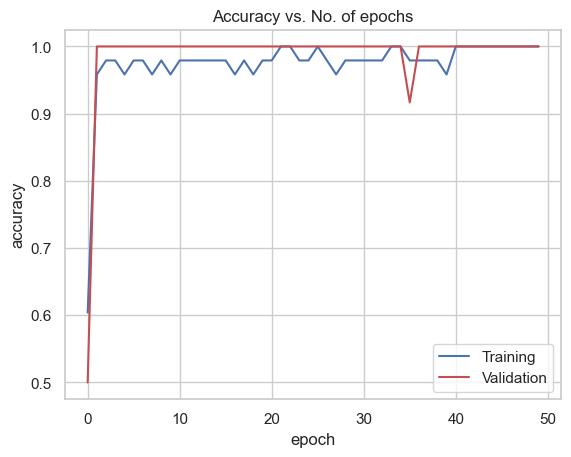

In [19]:
#   Accuracies
accs = []
stds = []

#   ROC AUCs
all_mean_fprs = []
all_mean_tprs = []
all_std_tprs = []
all_aucs = []

hist = None
best_acc = 0.0

#   cross_validate
for _ in range(20):
    acc_params, roc_params, history = gcn_aec.cross_validate(features_aec, graphs_aec, labels, 5, verbose=False)
    accs.append(acc_params[0])
    stds.append(acc_params[1])
    
    all_mean_fprs.append(roc_params[0])
    all_mean_tprs.append(roc_params[1])
    all_std_tprs.append(roc_params[2])
    all_aucs.append(roc_params[3])
    
    if (acc_params[0] > best_acc):
        hist = history
        best_acc = acc_params[0]

#   Print results
print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accs), np.mean(stds)))

mean_mean_fpr = np.mean(all_mean_fprs, axis=0)
mean_mean_tpr = np.mean(all_mean_tprs, axis=0)
mean_std_tpr = np.mean(all_std_tprs, axis=0)
mean_auc = np.mean(all_aucs)

#   Plot
plot_avg_roc_curve(mean_mean_fpr, mean_mean_tpr, mean_std_tpr, mean_auc)
plot_losses(hist)
plot_accuracies(hist)